
<div style="text-align: center; line-height: 0; padding-top: 9px;">  
  <img src="/dbfs/mnt/preventech/data/user_files/gf591/ML/fruits-360/MyProducePal_Logo.PNG" alt="Image">  
</div> 

# This notebook is developed to read weights of pre-trained PyTorch Model VGG16 and fine tune it using Fruits 360 dataset.

### Imports

In [1]:
import os
import random
import numpy as np
import pandas as pd
from PIL import Image
import torch
from torch import nn
import torch.utils.data.dataloader
import matplotlib.pyplot as plt
from torchvision import datasets
from torch.utils.data import DataLoader,Subset,random_split
from torchvision import transforms
from tqdm.auto import tqdm
from timeit import default_timer as timer
import torchvision
from pathlib import Path
from torchinfo import summary
from timeit import default_timer as timer
from PIL import Image


/Users/joshuajones/Desktop/IU_Grad_School/Courses/ENGR_E_533/Homework/Repos/ENGR_E533_Project/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Helper funcs

In [3]:
def device_setup() -> torch.DeviceObjType:
    if torch.cuda.is_available():
        device = torch.device("cuda")
        print("CUDA is available. Training on GPU.")
    
    elif torch.backends.mps.is_available():
        torch.backends.mps.benchmark = True
        device = torch.device("mps")
        print("MPS is available. Training with MPS.")
    
    else:
        device = torch.device("cpu")
        print("CUDA is not available. Training on CPU.")

    return device

def display_metadata(dataset, msg="") -> None:
    """Displays size and range of various input types, used for debugging"""
    if isinstance(dataset, torch.utils.data.Dataset):
        sample, _ = dataset[0]
        print(f'{msg} Dataset Shape: {dataset.data.shape}, Raw Min-Max: {dataset.data.min()}-{dataset.data.max()}, Min-Max: {sample.min().item():0.2f}-{sample.max().item():0.2f}')
    elif isinstance(dataset, torch.Tensor):
        print(f'{msg} Tensor Shape: {dataset.shape}, Min-Max: {dataset.min().item():0.2f}-{dataset.max().item():0.2f}')
    elif isinstance(dataset, list):
        print(f'{msg}   List Shape: {len(dataset)}, Min-Max: {min(dataset):0.2f}-{max(dataset):0.2f}')
    else:
        print(f"{msg} Unsupported type for metadata display: {type(dataset)}")

In [ ]:
# results_path = '/dbfs/mnt/preventech/data/user_files/gf591/ML/fruits-360/test_results_vgg16_finetuned.csv'
df_result = pd.read_csv(results_path)
df_result

### Setup Dataloaders

In [121]:
def get_fixed_samples_per_class(dataset: datasets, num_samples_per_class=10) -> Subset:

    class_indices = {}
    for idx, label in enumerate(dataset.targets):
        if label not in class_indices:
            class_indices[label] = []
        class_indices[label].append(idx)

    selected_indices = []
    for label, indices in class_indices.items():
        selected_indices.extend(random.sample(indices, num_samples_per_class))

    return Subset(dataset, selected_indices)


def reverse_transform(tensor, mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5), target_size=(100,100)):
    tensor = tensor.clone()
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)  
    
    tensor = torch.clamp(tensor, 0, 1)
    pil_image = transforms.functional.to_pil_image(tensor)
    resized_image = pil_image.resize(target_size, Image.BICUBIC)

    return resized_image



def plot_image_from_path(image_path:Path, target_size=(100,100)):
    assert image_path.is_file(), f'not a valid path {image_path}'
    img = Image.open(image_path)
    resized_image = img.resize(target_size, Image.BICUBIC)
    plt.imshow(resized_image)
    plt.axis('off')
    plt.title(f"{image_path.parent.name}/{image_path.stem}")
    plt.show()


class ImageFolderWithPaths(datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super().__getitem__(index)
        path = self.samples[index][0] 
        return (*original_tuple, path, index) 


In [ ]:
#define dataloader and class_names
def create_dataloaders(
    train_data,
    test_data,
    batch_size:int,
    num_workers:int=2,
    train_split = (0.8,0.2),
    device='cpu',
):

    # Split Training set into train and validation
    train_ratio, val_ratio = train_split
    total_samples = len(train_data)
    train_size = int(train_ratio * total_samples)
    val_size = total_samples - train_size
    train_subset, val_subset = random_split(train_data, [train_size, val_size])


    sample_image, sample_label = train_data[0]
    print(sample_image.shape, sample_image.min(), sample_image.max())


    # Setup Dataloaders
    train_dataloader=DataLoader(
        train_subset,
        batch_size=batch_size, #how many image should select in each iter
        shuffle=True, #mix the data
        num_workers=num_workers,
        pin_memory=True,
        persistent_workers=True,
    )

    val_dataloader=DataLoader(
        val_subset,
        batch_size=batch_size, 
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
        persistent_workers=True,
    )

    test_dataloader=DataLoader(
        test_data,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
        persistent_workers=True,
    )
    
    return train_dataloader,val_dataloader,test_dataloader

In [ ]:
# #Get the pretrained model
train_dir = "fruits-360/Training"
test_dir  = "fruits-360/Test"

batch_size = 32
device = device_setup()

if device==torch.device("mps"):
    torch.mps.empty_cache()  # Clears MPS memory cache which helps prevent memory leaks 

weights=torchvision.models.VGG16_Weights.DEFAULT
auto_transforms=weights.transforms()
print(auto_transforms)


train_data=datasets.ImageFolder(train_dir,transform=auto_transforms)
test_data=datasets.ImageFolder(test_dir,transform=auto_transforms)
# ImageFolder custom class stores real sample index and filepath with sample
test_dataset_with_paths = ImageFolderWithPaths(test_dir,transform=auto_transforms)

class_names=train_data.classes

# Get data loaders
train_dataloader,val_dataloader,test_dataloader = create_dataloaders(train_data, 
                                                                    test_data, 
                                                                    num_workers=4,
                                                                    batch_size=batch_size,
                                                                    device=device)



# Sample fixed # per class
test_subset = get_fixed_samples_per_class(test_dataset_with_paths,num_samples_per_class=10)
demo_test_dataloader=DataLoader(
    test_subset,
    batch_size=batch_size,
    shuffle=False,
    pin_memory=True,
)

model_vgg16=torchvision.models.vgg16(weights=weights)
for param in model_vgg16.parameters():
    param.requires_grad = False


curr_alloc=6382291200
drvr_alloc=7512736.0 KB
MPS is available. Training with MPS.
ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)
torch.Size([3, 224, 224]) tensor(-1.6127) tensor(2.6400)


### Inspect Dataloaders

In [124]:
len(train_dataloader.dataset), len(val_dataloader.dataset), len(test_dataloader.dataset), len(demo_test_dataloader.dataset)

(56392, 14099, 23619, 1410)

(64, 64)


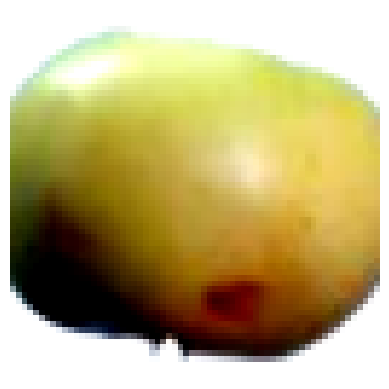

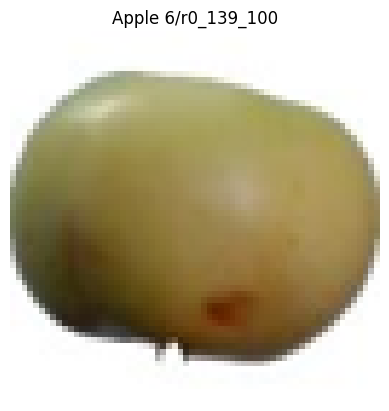

In [126]:
# Get the first batch of images from the dataloader  
for batch_idx, (images, labels, file_paths, indices) in enumerate(demo_test_dataloader):
    
    for i in range(len(images)):
        # Reverse Normalization
        image = images[i]
        image_t = reverse_transform(image, target_size=(64,64))    
        
        print(image_t.size)
        plt.imshow(image_t)  
        plt.axis('off')
        plt.show()  
        plot_image_from_path(Path(file_paths[i]), target_size=(64,64))    

        break
    break

In [127]:
summary(model=model_vgg16,
       input_size=(32,3,224,224),
       col_names=["input_size","output_size","num_params","trainable"],
       col_width=20,
       row_settings=["var_names"])


Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
VGG (VGG)                                [32, 3, 224, 224]    [32, 1000]           --                   False
├─Sequential (features)                  [32, 3, 224, 224]    [32, 512, 7, 7]      --                   False
│    └─Conv2d (0)                        [32, 3, 224, 224]    [32, 64, 224, 224]   (1,792)              False
│    └─ReLU (1)                          [32, 64, 224, 224]   [32, 64, 224, 224]   --                   --
│    └─Conv2d (2)                        [32, 64, 224, 224]   [32, 64, 224, 224]   (36,928)             False
│    └─ReLU (3)                          [32, 64, 224, 224]   [32, 64, 224, 224]   --                   --
│    └─MaxPool2d (4)                     [32, 64, 224, 224]   [32, 64, 112, 112]   --                   --
│    └─Conv2d (5)                        [32, 64, 112, 112]   [32, 128, 112, 112]  (73,856)             False
│    └─ReLU (6)

# Baseline:
Below model is to modify the fully connected (fc) layer of a pre-trained GoogleNet model in PyTorch by adding layers as below:
1. First layer is added to the sequential module with 1024 input features and 512 output features.
2. To reduce non-linearity and improve learning of model on complex patterns, a ReLu activation function is added in second layer to act on the output of the first layer
3. Third layer is added with drop out to reduce overfitting of the model by randomly dropping out some of the neurons during training for regularization.
4. Forth layer is added to generate output having total classes = number of classes in original dataset.
5. Last layer is added to take Log of SoftMax function on probability of the prediction belonging to each class.
By doing this, in this baseline model is  replacing the original fc layer of the pre-trained GoogleNet model with the new sequential module. 

In [ ]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device):
    model.train()
    correct_train, total_train = 0,0
    train_epoch_loss = 0
    for batch,(image,label) in enumerate(data_loader):
        image, label=image.to(device), label.to(device)
        
        # Forward Pass
        y_pred=model(image)
        loss=loss_fn(y_pred,label)
        running_loss += loss.item()
        
        # Back prop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Calc Acc
        y_pred_class=torch.argmax(torch.softmax(y_pred,dim=1),dim=1)
        correct_train +=(y_pred_class==label).sum().item()
        total_train += label.size(0)
        
    train_epoch_loss= running_loss / total_train
    train_accuracy = correct_train / total_train
    return train_epoch_loss,train_accuracy,model

def test_step(model:torch.nn.Module,
             data_loader: torch.utils.data.DataLoader,
              loss_fn:torch.nn.Module,
              device:torch.device): 
    
    correct_test, total_test = 0,0
    test_epoch_loss = 0
    running_loss=0
    results = []
    model.eval()
    with torch.inference_mode():
        for batch_idx, (images, labels, file_paths, indices) in enumerate(data_loader):
            images, labels=images.to(device), labels.to(device)    
            
            # Forward Pass
            test_pred_logits=model(images)
            loss=loss_fn(test_pred_logits,labels)
            running_loss += loss.item()

            # Get Predictions and Probabilities
            test_pred_probs = torch.softmax(test_pred_logits, dim=1)
            test_pred_labels = test_pred_probs.argmax(dim=1)

            # Store Results for Each Item in the Batch
            for i in range(len(images)):
                results.append({
                    "Image": batch_idx * batch_size + i + 1,  
                    "Image_Path": file_paths[i],  
                    "Label": test_dataset_with_paths.classes[labels[i].item()], 
                    "Prediction": test_dataset_with_paths.classes[test_pred_labels[i].item()], 
                    "Probability": test_pred_probs[i, test_pred_labels[i]].item()  
                })

            # Update metrics
            correct_test += (test_pred_labels == labels).sum().item()
            total_test += labels.size(0)
            
        test_epoch_loss = running_loss / total_test
        test_accuracy = correct_test / total_test
    return test_epoch_loss,test_accuracy, results

def train_and_test(model:torch.nn.Module,
          train_dataloader:torch.utils.data.DataLoader,
          test_dataloader:torch.utils.data.DataLoader,
          optimizer:torch.optim.Optimizer,
          loss_fn:torch.nn.Module,
          epochs:int,
          device):
    results={"train_loss":[],
             "train_acc":[],
             "test_loss":[],
             "test_acc":[],
             "model":None}
    train_loss = 0
    train_acc = 0
    for epoch in tqdm(range(epochs)):
        train_start=timer()
        train_loss,train_acc,model=train_step(model=model,
                                       data_loader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer,
                                       device=device)
        test_start=timer()
        test_loss,test_acc,_ =test_step(model=model,
                                       data_loader=test_dataloader,
                                       loss_fn=loss_fn,
                                       device=device)
        print(f"Epoch:{epoch}\
              train_loss:{train_loss:.4f}\
              train_acc:{train_acc:.4f}\
              train_time:{test_start-train_start:.2f}\
              test_loss:{test_loss:.4f}\
              test_acc:{test_acc:.4f}\
              test_time:{timer()-test_start:.2f}")
        
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
        results["model"] = model
    
    return results


In [74]:
def estimate_memory(batch_size, image_size, channels, dtype=torch.float32):
    bytes_per_element = torch.tensor([], dtype=dtype).element_size()
    total_bytes = batch_size * image_size[0] * image_size[1] * channels * bytes_per_element
    total_mb = total_bytes / (1024 ** 2)
    return total_mb

memory_usage_mb = estimate_memory(batch_size=batch_size, image_size=(224, 224), channels=3, dtype=torch.float32)
print(f"Estimated memory usage per batch: {memory_usage_mb:.2f} MB")

def save_results(results:dict, save_dir:Path):
    for attr_name,attr in results.items():
        full_stem_path = Path(f'{save_dir}/{attr_name}')
        
        # Accuracy and Loss
        if isinstance(attr, list):
            np.save(full_stem_path.with_suffix('.npy'),  np.array(attr))
    
        # PyTorch Model
        elif isinstance(attr, nn.Module):
            torch.save(attr.state_dict(), full_stem_path.with_suffix('.pt'))

        else:
            raise TypeError(f"Unexpected type, {attr_name} not saved")
            
        print(f'Data saved to disk: {full_stem_path}')

Estimated memory usage per batch: 18.38 MB


#### Setup

In [107]:
device = device_setup()
num_classes = len(class_names)

model_vgg16.fc = nn.Sequential(
    nn.Linear(1024,512), nn.ReLU(), nn.Dropout(0.4),
    nn.Linear(512, num_classes), nn.LogSoftmax(dim=1)
    ).to(device)

optimizer=torch.optim.Adam(params=model_vgg16.parameters(),lr=0.001)
loss_fn=nn.CrossEntropyLoss()

# Save model, accuracy, and loss per epoch
experiment = "transfer_learning"
model_description = "vgg16_baseline_test"
save_dir = Path(f'{os.getcwd()}/{experiment}/{model_description}')
save_dir.mkdir(parents=True, exist_ok=True)
assert save_dir.exists(),f'Path to Save directory is not valid:\n{save_dir}' 

model_vgg16 = model_vgg16.requires_grad_(True).to(device)

MPS is available. Training with MPS.


#### Load Model

In [137]:
def create_modified_vgg16(num_classes=141):
    model = torchvision.models.vgg16(pretrained=False)
    model.fc = torch.nn.Sequential(
        torch.nn.Linear(1024, 512),
        torch.nn.ReLU(),
        torch.nn.Dropout(0.4),
        torch.nn.Linear(512, num_classes),
        torch.nn.LogSoftmax(dim=1)
    )
    return model

def load_results(load_dir: Path, model_class=None, optimizer_class=None, device="cpu") -> dict:
    results = {}
    
    for file_path in load_dir.iterdir():
        attr_name = file_path.stem
        ext = file_path.suffix
        
        # Load loss or accuracy arrays
        if ext == ".npy":
            results[attr_name] = np.load(file_path, allow_pickle=True).tolist()
        
        # Load torch model
        elif ext == ".pt":
            if "weights" in attr_name:  # Weights-only file
                if model_class is None:
                    raise ValueError(f"Cannot load weights from {file_path} without a model class.")
                
                model = model_class  # Instantiate the model
                model.load_state_dict(torch.load(file_path, map_location=device))
                results["model"] = model
                print(f"Model weights loaded from {file_path}")
            
            else:  # Full checkpoint file
                checkpoint = torch.load(file_path, map_location=device, weights_only=False)
                
                if model_class is None:
                    raise ValueError(f"Cannot load checkpoint from {file_path} without a model class.")
                
                # Load model state
                model = model_class
                model.load_state_dict(checkpoint["model_state_dict"])
                results["model"] = model
                
                # Load optimizer state (if optimizer class provided)
                if optimizer_class:
                    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
                    results["optimizer"] = optimizer
                
                # Add metadata (epoch, loss, accuracy)
                results["epoch"] = checkpoint.get("epoch", None)
                results["loss"] = checkpoint.get("loss", None)
                results["accuracy"] = checkpoint.get("accuracy", None)
                
                print(f"Checkpoint loaded from {file_path}")
        else:
            raise TypeError(f"Unexpected file type: {file_path}")
        
        print(f"Data loaded from disk: {file_path}")
    
    return results



experiment = "model_vgg16_finetuned_15epochs"
load_dir = Path(f'{os.getcwd()}/{experiment}')


model_class = create_modified_vgg16()
loaded_results = load_results(load_dir, model_class=model_class, optimizer_class=optimizer, device="cpu")

loaded_results = load_results(load_dir, model_class=model_class, device=device)
loaded_model = loaded_results["model"].to(device)
print(loaded_results.keys())

/Users/joshuajones/Desktop/IU_Grad_School/Courses/ENGR_E_533/Homework/Repos/ENGR_E533_Project/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/joshuajones/Desktop/IU_Grad_School/Courses/ENGR_E_533/Homework/Repos/ENGR_E533_Project/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Checkpoint loaded from /Users/joshuajones/Desktop/IU_Grad_School/Courses/ENGR_E_533/Homework/Repos/ENGR_E533_Project/model_vgg16_finetuned_15epochs/model.pt
Data loaded from disk: /Users/joshuajones/Desktop/IU_Grad_School/Courses/ENGR_E_533/Homework/Repos/ENGR_E533_Project/model_vgg16_finetuned_15epochs/model.pt
Checkpoint loaded from /Users/joshuajones/Desktop/IU_Grad_School/Courses/ENGR_E_533/Homework/Repos/ENGR_E533_Project/model_vgg16_finetuned_15epochs/model.pt
Data loaded from disk: /Users/joshuajones/Desktop/IU_Grad_School/Courses/ENGR_E_533/Homework/Repos/ENGR_E533_Project/model_vgg16_finetuned_15epochs/model.pt
dict_keys(['model', 'epoch', 'loss', 'accuracy'])


#### Run Inference with Demo Dataset

In [ ]:
start_time=timer()
test_loss,test_acc,test_results=test_step(model=loaded_model,
                    data_loader=demo_test_dataloader,
                    loss_fn=loss_fn,
                    device=device)

print(f"[INFO]Total Test time= {timer()-start_time:.3f} seconds")

results_df = pd.DataFrame(test_results)

# Save to CSV file for streamlit 
results_csv_path = f"{os.getcwd()}/demo_results.csv"
results_df.to_csv(results_csv_path, index=False)
print(f"Results saved to {results_csv_path}")

[INFO]Total Test time= 32.897 seconds
   Image                              Image_Path    Label Prediction  \
0      1  fruits-360/Test/Apple 6/r0_139_100.jpg  Apple 6    Apple 6   
1      2  fruits-360/Test/Apple 6/r1_199_100.jpg  Apple 6    Apple 6   
2      3   fruits-360/Test/Apple 6/r1_39_100.jpg  Apple 6    Apple 6   
3      4  fruits-360/Test/Apple 6/r1_279_100.jpg  Apple 6    Apple 6   

   Probability  
0          1.0  
1          1.0  
2          1.0  
3          1.0  
Results saved to /Users/joshuajones/Desktop/IU_Grad_School/Courses/ENGR_E_533/Homework/Repos/ENGR_E533_Project/demo_results.csv
